In [31]:
import torch
import pandas as pd
import numpy as np
from transformers import SwinForImageClassification
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms

# ✅ Swin-base 모델용 transform 정의
swin_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])



# ✅ 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ 모델 구조 불러오기
model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=2,
    ignore_mismatched_sizes=True
)

# ✅ 훈련된 모델 파라미터 로드 (GPU ↔ CPU 문제 해결)
checkpoint = torch.load("best_model_epoch3.pt", map_location=device)
model.load_state_dict(checkpoint)
model = model.to(device)
model.eval()

# ✅ 테스트 함수 정의
def test_model(model, test_loader, device, has_labels=True):
    all_predictions = []
    all_labels = []
    all_filenames = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            if has_labels:
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)
            else:
                images, filenames = batch
                images = images.to(device)
                all_filenames.extend(filenames)
            
            outputs = model(pixel_values=images).logits
            _, predicted = outputs.max(1)

            if has_labels:
                all_labels.extend(labels.cpu().numpy())
            
            all_predictions.extend(predicted.cpu().numpy())

    if has_labels:
        return all_predictions, all_labels
    else:
        return all_predictions, all_filenames


Using device: cpu


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
class TestDataset(Dataset):
    def __init__(self, csv_file, img_dir):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = swin_transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # ✅ 'id' 컬럼 사용
        full_id_path = self.data.iloc[idx]['id']
        img_name = os.path.basename(full_id_path)
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        if 'label' in self.data.columns:
            label = self.data.iloc[idx]['label']
            return image, label
        else:
            return image, img_name


In [27]:
test_df = pd.read_csv('./archive/test.csv', index_col=0)

# ✅ file_name 열을 인덱스에서 추출하여 따로 생성
test_df['file_name'] = test_df.index.map(lambda x: os.path.basename(x))
print(test_df.head())



                                                                              file_name
id                                                                                     
test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg  1a2d9fd3e21b4266aea1f66b30aed157.jpg
test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg  ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg  eb364dd2dfe34feda0e52466b7ce7956.jpg
test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg  f76c2580e9644d85a741a42c6f6b39c0.jpg
test_data_v2/a16495c578b7494683805484ca27cf9f.jpg  a16495c578b7494683805484ca27cf9f.jpg


In [33]:
# ✅ index_col 제거!
test_df = pd.read_csv('./archive/test.csv')

# 테스트 데이터셋
test_dataset = TestDataset(
    csv_file='./archive/test.csv',
    img_dir='./archive/test_data_v2'
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 테스트 실행 후 저장
predictions, filenames = test_model(model, test_loader, device, has_labels=False)

# ✅ 제출 포맷에 맞게 저장
results_df = pd.DataFrame({
    'id': test_df['id'],         # 정확히 test.csv의 id 컬럼 그대로
    'label': predictions         # Kaggle에서 요구한 'label' 이름
})
results_df.to_csv("test_predictions.csv", index=False)


Testing: 100%|██████████| 174/174 [12:27<00:00,  4.30s/it]


Using device: cpu


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Testing: 100%|██████████| 174/174 [12:36<00:00,  4.35s/it]


✅ test_predictions.csv 저장 완료!


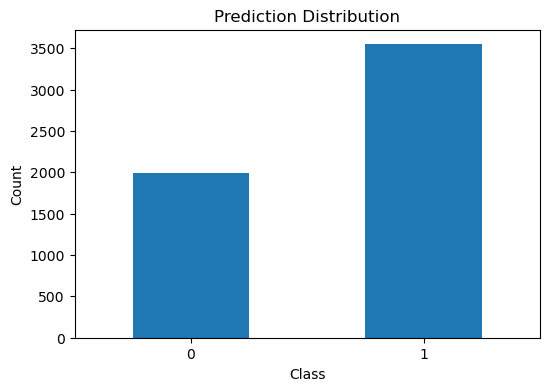

In [19]:
import torch
import pandas as pd
import numpy as np
from transformers import SwinForImageClassification
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms

# ✅ 1. Transform 정의
swin_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ✅ 2. Test Dataset 클래스 정의
class TestDataset(Dataset):
    def __init__(self, csv_file, img_dir):
        self.data = pd.read_csv(csv_file, index_col=0)
        self.img_dir = img_dir

        # 🔽 file_name 컬럼 생성 (인덱스에서 추출)
        self.data['file_name'] = self.data.index.map(lambda x: os.path.basename(x))
        self.transform = swin_transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['file_name']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        if 'label' in self.data.columns:
            label = self.data.iloc[idx]['label']
            return image, label
        else:
            return image, img_name

# ✅ 3. 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ 4. 모델 로드
model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=2,
    ignore_mismatched_sizes=True
)

# 🔽 best_model.pt 로드 (CPU 대응도 포함)
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model = model.to(device)
model.eval()

# ✅ 5. 테스트 데이터셋 로드
csv_path = "./archive/test.csv"
img_dir = "./archive/test_data_v2"
test_df = pd.read_csv(csv_path, index_col=0)
test_df['file_name'] = test_df.index.map(lambda x: os.path.basename(x))

test_dataset = TestDataset(csv_file=csv_path, img_dir=img_dir)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ✅ 6. 예측 함수
def test_model(model, test_loader, device, has_labels=True):
    all_predictions = []
    all_labels = []
    all_filenames = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            if has_labels:
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)
            else:
                images, filenames = batch
                images = images.to(device)
                all_filenames.extend(filenames)

            outputs = model(pixel_values=images).logits
            _, predicted = outputs.max(1)

            if has_labels:
                all_labels.extend(labels.cpu().numpy())

            all_predictions.extend(predicted.cpu().numpy())

    if has_labels:
        return all_predictions, all_labels
    else:
        return all_predictions, all_filenames

# ✅ 7. 예측 및 저장
if 'label' in test_df.columns:
    predictions, true_labels = test_model(model, test_loader, device, has_labels=True)

    # 🔷 혼동 행렬 시각화
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 🔷 결과 저장
    results_df = pd.DataFrame({
        'id': test_df.index,  # ✅ index를 id로 사용
        'True_Label': true_labels,
        'Predicted_Label': predictions
    })
else:
    predictions, filenames = test_model(model, test_loader, device, has_labels=False)
    results_df = pd.DataFrame({
        'id': filenames,
        'Predicted_Label': predictions
    })

# ✅ 8. CSV 저장
results_df.to_csv("test_predictions.csv", index=False)
print("✅ test_predictions.csv 저장 완료!")

# ✅ 9. 예측 분포 시각화
plt.figure(figsize=(6, 4))
pd.Series(predictions).value_counts().sort_index().plot(kind='bar')
plt.title("Prediction Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()
